In [0]:
pip install kaggle


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"polojushashidharsai","key":"f220544527efd7805dc36e63fb1c78b1"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset -p /content

100% 3.57G/3.58G [00:59<00:00, 56.5MB/s]
100% 3.58G/3.58G [00:59<00:00, 65.0MB/s]


In [0]:
!unzip \*.zip

Archive:  real-life-violence-situations-dataset.zip
  inflating: Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_109.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_11.mp4  
  inflating: Real Life Violence Dataset/N

In [0]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12883 sha256=bb37cecd4267fba0c362053389fc411c4f42b88ade1fe81a88b53a8057eb32bd
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [0]:
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = ['Violence', 'NonViolence']
classes.sort()
# some global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 8
BS = 8
# pattern to get videos and classes
glob_pattern = '/content/Real Life Violence Dataset/{classname}/*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    rotation_range=8,
    width_shift_range=.1,
    height_shift_range=.1)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.10, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Using TensorFlow backend.


class NonViolence, validation count: 100, train count: 900
class Violence, validation count: 100, train count: 900
Total data: 2 classes for 1800 files for train


In [0]:
valid = train.get_validation_generator()


Total data: 2 classes for 200 files for validation


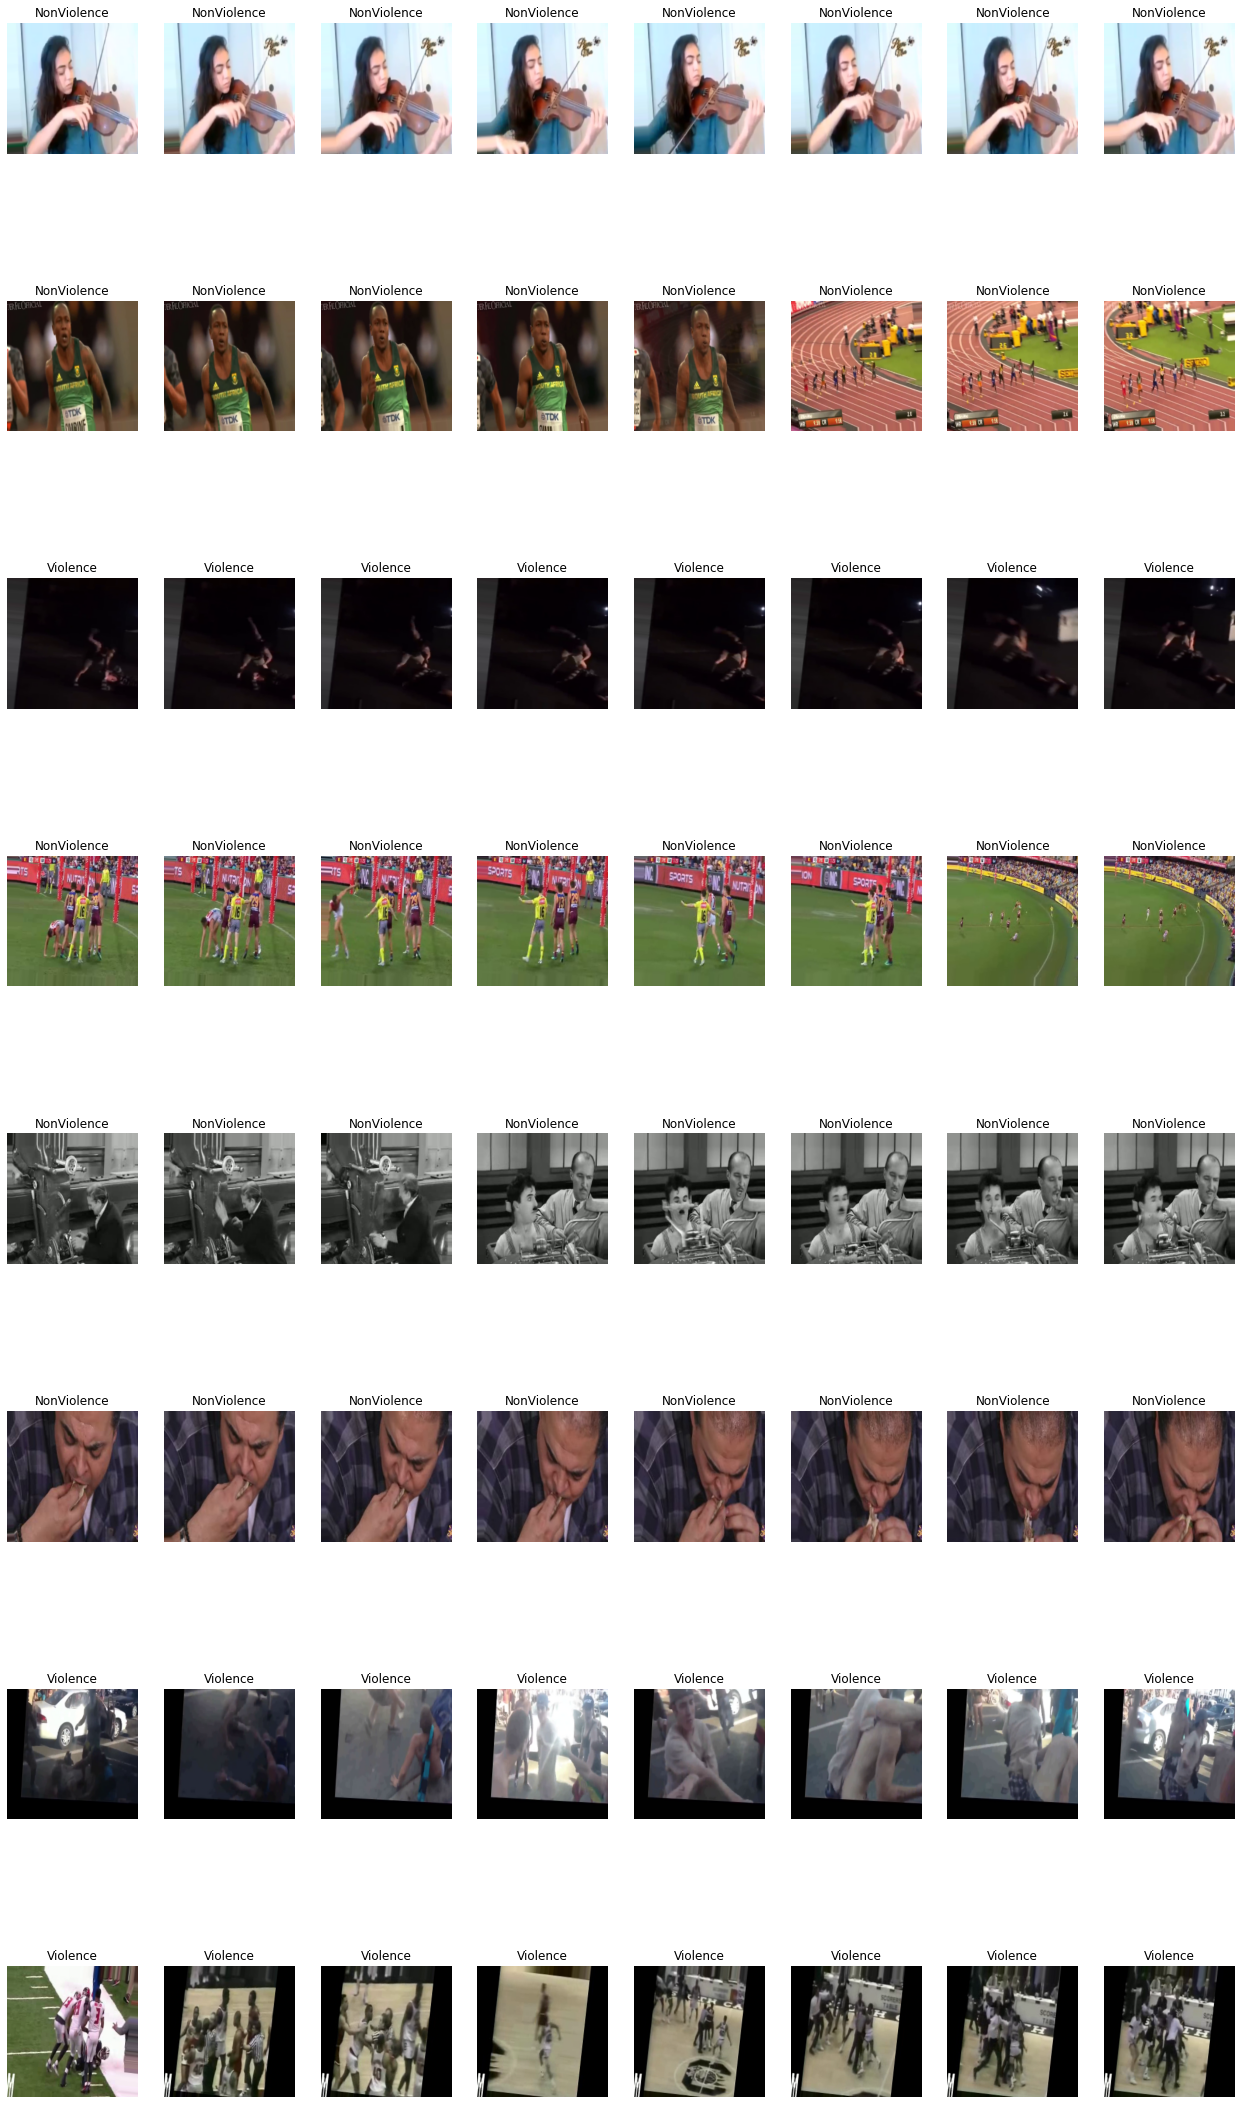

In [0]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [0]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [0]:
def build_alexnet(shape=(224, 224, 3), nbout=2):
  input = Input(shape)
  
  # actually batch normalization didn't exist back then
  # they used LRN (Local Response Normalization) for regularization
  x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(256, 5, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  
  output = Dense(nbout, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [0]:
def action_model(shape=(8, 112, 112, 3), nbout=2):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_alexnet(shape[1:], nbout = 2)
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape = shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model
    # ...

In [0]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD()
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [0]:
!mkdir chkp
EPOCHS=30
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

mkdir: cannot create directory ‘chkp’: File exists
Epoch 1/30
222/225 [============================>.] - ETA: 31s - loss: 0.6937 - acc: 0.4831